This is vertion 5 of our work, changes we made:

1)made many optemzation for time retrival

2)tested many vareation of parameters for bm 25 and and weight for title and pagerank

3)compared diffrent models

4)implemented read and write for pagerank


In [ ]:
# if the following command generates an error, you probably didn't enable
# the cluster security option "Allow API access to all Google Cloud services"
# under Manage Security → Project Access when setting up the cluster
!gcloud dataproc clusters list --region us-central1

NAME          PLATFORM  PRIMARY_WORKER_COUNT  SECONDARY_WORKER_COUNT  STATUS   ZONE           SCHEDULED_DELETE
cluster-1d7a  GCE       4                                             RUNNING  us-central1-a


# Imports & Setup

In [ ]:
!pip install -q google-cloud-storage==1.43.0
!pip install -q graphframes

In [2]:
# import pyspark
import sys
from collections import Counter, OrderedDict, defaultdict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from pathlib import Path
import pickle
import pandas as pd
from google.cloud import storage

import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# if nothing prints here you forgot to include the initialization script when starting the cluster
!ls -l /usr/lib/spark/jars/graph*

ls: cannot access '/usr/lib/spark/jars/graph*': No such file or directory


In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.sql import SQLContext
from graphframes import *

In [ ]:
spark

In [ ]:
# Put your bucket name below and make sure you can access it without an error
bucket_name = 'bucket-mr-project-ir-david'
#full_path = f"gs://{bucket_name}/wiki_dump/"
full_path = "gs://bucket-mr-project-ir-david/"
paths=[]

client = storage.Client()
blobs = client.list_blobs(bucket_name)
for b in blobs:
    if b.name.startswith('wiki_dump/') and b.name != 'wiki_dump/graphframes.sh' and b.name != 'wiki_dump/':
        paths.append(full_path + b.name)


***GCP setup is complete!*** If you got here without any errors you've earned 10 out of the 35 points of this part.

# Building an inverted index

buliding inverted on 1000000 docs and the terms only from the jason file


In [ ]:
# take the 'text' and 'id' or the first 1000 rows and create an RDD from it
#remove this later
parquetFile = spark.read.parquet(*paths)
doc_text_pairs = parquetFile.select("text", "id").rdd
doc_title_pairs = parquetFile.select("id", "title").rdd
print(doc_title_pairs.take(1))

We will count the number of pages to make sure we are looking at the entire corpus. The number of pages should be more than 6M

In [ ]:
# Count number of wiki pages
doc_amount = parquetFile.count()
print(doc_amount)

6348910


In [ ]:
# if nothing prints here you forgot to upload the file inverted_index_gcp.py to the home dir
%cd -q /home/dataproc
!ls inverted_index_gcp.py

[Errno 2] No such file or directory: '/home/dataproc'
inverted_index_gcp.py


In [ ]:
# adding our python module to the cluster
sc.addFile("/home/dataproc/inverted_index_gcp.py")
sys.path.insert(0,SparkFiles.getRootDirectory())

In [3]:
from inverted_index_gcp import InvertedIndex

all the logic

In [ ]:
NUM_BUCKETS = 124
stemmer = PorterStemmer()

def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS
bucket_name = "bucket-mr-project-ir-david"
base_dir = "inverted_on_text_without_stem"

english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links",
                    "may", "first", "see", "history", "people", "one", "two",
                    "part", "thumb", "including", "second", "following",
                    "many", "however", "would", "became"]

all_stopwords = english_stopwords.union(corpus_stopwords)
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)

NUM_BUCKETS = 124
def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS

# PLACE YOUR CODE HERE

def word_count(text, id):
  ''' Count the frequency of each word in `text` (tf) that is not included in
  `all_stopwords` and return entries that will go into our posting lists.
  Parameters:
  -----------
    text: str
      Text of one document
    id: int
      Document id
  Returns:
  --------
    List of tuples
      A list of (token, (doc_id, tf)) pairs
      for example: [("Anarchism", (12, 5)), ...]
  '''

  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  len_of_doc = len(tokens)
  # YOUR CODE HERE
  word_counts = Counter(tokens)
    # Filter out stopwords and create tuples of (token, (doc_id, tf))
  result = [(token, (id, tf)) for token, tf in word_counts.items() if token not in all_stopwords ]
  return result

# Initialize sum_doc_len
sc = SparkContext.getOrCreate()
sum_doc_len = sc.accumulator(0)
def doc_len(text, id):
  global sum_doc_len
  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  tokens_without_stop_w = [token for token in tokens if token not in all_stopwords]
  sum_doc_len += len(tokens_without_stop_w)
  return id, len(tokens_without_stop_w)

def reduce_word_counts(unsorted_pl):
  ''' Returns a sorted posting list by wiki_id.
  Parameters:
  -----------
    unsorted_pl: list of tuples
      A list of (wiki_id, tf) tuples
  Returns:
  --------
    list of tuples
      A sorted posting list.
  '''
  # YOUR CODE HERE
  # Sort the posting list by wiki_id
  sorted_pl = sorted(unsorted_pl, key=lambda x: x[0])
  return sorted_pl

def calculate_df(postings):
  ''' Takes a posting list RDD and calculate the df for each token.
  Parameters:
  -----------
    postings: RDD
      An RDD where each element is a (token, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each element is a (token, df) pair.
  '''
  # YOUR CODE HERE
  # Calculate the length of each posting list for each token
  token_document_counts = postings.map(lambda x: (x[0], len(x[1])))

  return token_document_counts

def partition_postings_and_write(postings):
  ''' A function that partitions the posting lists into buckets, writes out
  all posting lists in a bucket to disk, and returns the posting locations for
  each bucket. Partitioning should be done through the use of `token2bucket`
  above. Writing to disk should use the function  `write_a_posting_list`, a
  static method implemented in inverted_index_colab.py under the InvertedIndex
  class.
  Parameters:
  -----------
    postings: RDD
      An RDD where each item is a (w, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each item is a posting locations dictionary for a bucket. The
      posting locations maintain a list for each word of file locations and
      offsets its posting list was written to. See `write_a_posting_list` for
      more details.
  '''
  # YOUR CODE HERE
  def write_partition_to_disk(partition):
        ''' Writes a partition of posting lists to disk and returns the posting
        locations for each word in the partition.
        Parameters:
        -----------
            partition: iterator
                An iterator of (bucket_id, posting_lists) tuples.
        Returns:
        --------
            tuple
                A tuple containing the bucket ID and the posting locations dictionary
                for the partition.
        '''
        bucket_id, posting_lists = partition
        bucket_id , posting_locs = InvertedIndex.write_a_posting_list((bucket_id, posting_lists),base_dir,bucket_name)
        return posting_locs
  # Partition the posting lists into buckets
  bucketed_postings = postings.map(lambda x: (token2bucket_id(x[0]), [x])) \
                               .reduceByKey(lambda a, b: a + b)

    # Write out each bucket to disk and collect the posting locations
  posting_locations = bucketed_postings.map(write_partition_to_disk)

  return posting_locations



############################################# page rank
def generate_graph(pages):
  ''' Compute the directed graph generated by wiki links.
  Parameters:
  -----------
    pages: RDD
      An RDD where each row consists of one wikipedia articles with 'id' and
      'anchor_text'.
  Returns:
  --------
    edges: RDD
      An RDD where each row represents an edge in the directed graph created by
      the wikipedia links. The first entry should the source page id and the
      second entry is the destination page id. No duplicates should be present.
    vertices: RDD
      An RDD where each row represents a vetrix (node) in the directed graph
      created by the wikipedia links. No duplicates should be present.
  '''
  # YOUR CODE HERE

  # Extract edges from the 'id' and 'anchor_text' fields of the RDD
  edges = pages.flatMap(lambda row: [(row.id, anchor.id) for anchor in row.anchor_text])

  # Remove duplicates from edges
  edges = edges.distinct()

  vertices = edges.flatMap(lambda edge: ([(edge[0],edge[0]),(edge[1],edge[1])])).distinct()


  return edges, vertices


create inverted_on_text_without_stem

In [ ]:
# time the index creation time
t_start = time()
path_to_dicts = "inverted_on_text_without_stem/dicts_folder"
# Create inverted index instance
inverted = InvertedIndex()

num_dictionaries = 11
# print("1")
dict_len_docs_rdd = doc_text_pairs.map(lambda x : doc_len(x[0], x[1]))
count = dict_len_docs_rdd.count()

print("2")
dict_len_dictionary_rdd = []
print("3")
for i in range(num_dictionaries):
    dict_len_dictionary_rdd.append(dict_len_docs_rdd.filter(lambda x: x[0]%num_dictionaries == i))
    print("4")
doc_title_dictionary_rdds = []
for i in range(num_dictionaries):
    doc_title_dictionary_rdds.append(doc_title_pairs.filter(lambda x: x[0]%num_dictionaries == i))
    print("5")
for i,rdd in enumerate(dict_len_dictionary_rdd):
    # Collect the documents from the RDD and convert them into a dictionary
    print("6")
    dictionary = rdd.collectAsMap()
    print("7")
    sample_dict = rdd.first()
    hash_num = (sample_dict[0])%num_dictionaries
    #Write the dictionary using inverted.write_dict()
    inverted.write_dict(dictionary, f'doc_len{hash_num}',bucket_name,path_to_dicts)
print("8")
counter = 0
for i, rdd in enumerate(doc_title_dictionary_rdds):
    # Collect the documents from the RDD and convert them into a dictionary
    dictionary = rdd.collectAsMap()
    print("9")
    sample_dict = rdd.first()
    hash_num = (sample_dict[0])%num_dictionaries
    #Write the dictionary using inverted.write_dict()
    inverted.write_dict(dictionary, f'doc_title{hash_num}',bucket_name,path_to_dicts)
print("10")


# word counts map
word_counts = doc_text_pairs.flatMap(lambda x: word_count(x[0], x[1]))
print("11")
postings = word_counts.groupByKey().mapValues(reduce_word_counts)
print("12")
# filtering postings and calculate df
postings_filtered = postings.filter(lambda x: len(x[1])>50)
w2df = calculate_df(postings_filtered)

w2df_dict = w2df.collectAsMap()



# partition posting lists and write out
posting_locs_list = partition_postings_and_write(postings_filtered).collect()


# collect all posting lists locations into one super-set
super_posting_locs = defaultdict(list)
for blob in client.list_blobs(bucket_name, prefix='inverted_on_text_without_stem'):
  if not blob.name.endswith("locs.pickle"):
    continue
  with blob.open("rb") as f:
    posting_locs = pickle.load(f)
    for k, v in posting_locs.items():
      super_posting_locs[k].extend(v)

print("13")

# pages_links = spark.read.parquet(path).limit(1000).select("id", "anchor_text").rdd
# edges, vertices = generate_graph(pages_links)
# edgesDF = edges.toDF(['src', 'dst']).repartition(4, 'src')
# verticesDF = vertices.toDF(['id']).repartition(4, 'id')
# g = GraphFrame(verticesDF, edgesDF)
# pr_results = g.pageRank(resetProbability=0.15, maxIter=10)
# pr = pr_results.vertices.select("id", "pagerank")
# pr = pr.sort(col('pagerank').desc())
# pr.repartition(1).write.csv('pr', compression="gzip")
# pr.show()

# Adding the posting locations dictionary to the inverted index
inverted.posting_locs = super_posting_locs
# Add the token - df dictionary to the inverted index
inverted.df = w2df_dict
# inverted.document_len = dict_len_docs
# inverted.doc_title_dict = dict_doc_title
inverted.avg_doc_len = sum_doc_len.value/doc_amount
inverted.doc_amount = doc_amount
# write the global stats out
inverted.write_index(base_dir, 'inverted_text_index_v5',bucket_name)
# # upload to gs
# index_src = "index.pkl"
# index_dst = f'gs://{bucket_name}/postings_gcp/{index_src}'
# !gsutil cp $index_src $index_dst

index_const_time = time() - t_start

create pagerank

In [ ]:
#pagerank
path_to_dicts = "inverted_on_text_without_stem/dicts_folder"

t_start = time()
pages_links = parquetFile.select ("id","anchor_text").rdd
# construct the graph
edges, vertices = generate_graph(pages_links)
# compute PageRank
edgesDF = edges.toDF(['src', 'dst']).repartition(124, 'src')
verticesDF = vertices.toDF(['id']).repartition(124, 'id')
g = GraphFrame(verticesDF, edgesDF)
pr_results = g.pageRank(resetProbability=0.15, maxIter=6)
pr = pr_results.vertices.select("id", "pagerank")
pr_rdd = pr.rdd



num_dictionaries = 11
# print("1")


print("2")
dict_pagerank_dictionary_rdd = []
print("3")
for i in range(num_dictionaries):
    dict_pagerank_dictionary_rdd.append(pr_rdd.filter(lambda x: x[0]%num_dictionaries == i))
    print("4")
for i,rdd in enumerate(dict_len_dictionary_rdd):
    # Collect the documents from the RDD and convert them into a dictionary
    print("6")
    dictionary = rdd.collectAsMap()
    print("7")
    sample_dict = rdd.first()
    hash_num = (sample_dict[0])%num_dictionaries
    #Write the dictionary using inverted.write_dict()
    inverted.write_dict(dictionary, f'doc_pagerank{hash_num}',bucket_name,path_to_dicts)
print("8")

pr_time = time() - t_start



In [ ]:
createing inverted index title instance


In [ ]:
# time the index creation time
t_start = time()
path_to_dicts = "inverted_on_text/dicts_folder"
# Create inverted index instance
inverted_title = InvertedIndex()

num_dictionaries = 11
# print("1")
dict_len_docs_rdd = doc_text_pairs.map(lambda x : doc_len(x[0], x[1]))
count = dict_len_docs_rdd.count()
print("2")
dict_len_dictionary_rdd = []
print("3")
for i in range(num_dictionaries):
    dict_len_dictionary_rdd.append(dict_len_docs_rdd.filter(lambda x: x[0]%num_dictionaries == i))
    print("4")
doc_title_dictionary_rdds = []
for i in range(num_dictionaries):
    doc_title_dictionary_rdds.append(doc_title_pairs.filter(lambda x: x[0]%num_dictionaries == i))
    print("5")
for i,rdd in enumerate(dict_len_dictionary_rdd):
    # Collect the documents from the RDD and convert them into a dictionary
    print("6")
    dictionary = rdd.collectAsMap()
    print("7")
    sample_dict = rdd.first()
    hash_num = (sample_dict[0])%num_dictionaries
    #Write the dictionary using inverted.write_dict()
    inverted.write_dict(dictionary, f'doc_len{hash_num}',bucket_name,path_to_dicts)
print("8")
counter = 0
for i, rdd in enumerate(doc_title_dictionary_rdds):
    # Collect the documents from the RDD and convert them into a dictionary
    dictionary = rdd.collectAsMap()
    print("9")
    sample_dict = rdd.first()
    hash_num = (sample_dict[0])%num_dictionaries
    #Write the dictionary using inverted.write_dict()
    inverted.write_dict(dictionary, f'doc_title{hash_num}',bucket_name,path_to_dicts)
print("10")

# word counts map
word_counts = doc_text_pairs.flatMap(lambda x: word_count(x[0], x[1]))
print("11")
postings = word_counts.groupByKey().mapValues(reduce_word_counts)
print("12")
# filtering postings and calculate df
postings_filtered = postings.filter(lambda x: len(x[1])>25)
w2df = calculate_df(postings_filtered)

w2df_dict = w2df.collectAsMap()



# partition posting lists and write out
posting_locs_list = partition_postings_and_write(postings_filtered).collect()


# collect all posting lists locations into one super-set
super_posting_locs = defaultdict(list)
for blob in client.list_blobs(bucket_name, prefix='inverted_on_title_without_stem'):
  if not blob.name.endswith("locs.pickle"):
    continue
  with blob.open("rb") as f:
    posting_locs = pickle.load(f)
    for k, v in posting_locs.items():
      super_posting_locs[k].extend(v)

print("13")

# pages_links = spark.read.parquet(path).limit(1000).select("id", "anchor_text").rdd
# edges, vertices = generate_graph(pages_links)
# edgesDF = edges.toDF(['src', 'dst']).repartition(4, 'src')
# verticesDF = vertices.toDF(['id']).repartition(4, 'id')
# g = GraphFrame(verticesDF, edgesDF)
# pr_results = g.pageRank(resetProbability=0.15, maxIter=10)
# pr = pr_results.vertices.select("id", "pagerank")
# pr = pr.sort(col('pagerank').desc())
# pr.repartition(1).write.csv('pr', compression="gzip")
# pr.show()

# Adding the posting locations dictionary to the inverted index
inverted_title.posting_locs = super_posting_locs
# Add the token - df dictionary to the inverted index
inverted_title.df = w2df_dict

inverted_title.avg_doc_len = sum_doc_len/doc_amount
inverted.doc_amount = doc_amount
# write the global stats out
inverted_title.write_index(base_dir, 'inverted_title_index_v5',bucket_name)
# # upload to gs
# index_src = "index.pkl"
# index_dst = f'gs://{bucket_name}/postings_gcp/{index_src}'
# !gsutil cp $index_src $index_dst

index_const_time = time() - t_start

upload the index from the bucket


In [4]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

In [22]:
# load_from_bucket
# get textIndex.pkl from bucket
path_to_dicts = "inverted_on_text/dicts_folder"
from google.cloud import storage
import pickle
bucket_name = 'bucket-mr-project-ir-david'
file_path1 = "inverted_on_text_without_stem/inverted_text_index_v5.pkl"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(file_path1)
contents = blob.download_as_bytes()
inverted = pickle.loads(contents)
inverted.document_len = inverted.read_dict("doc_len",bucket_name,path_to_dicts)

# num_dictionaries = 11
# doc_title_dictionaries = []
# for i in range(num_dictionaries):
#     dict_i = inverted.read_dict(f'doc_title{i}',bucket_name,path_to_dicts)
#     doc_title_dictionaries.append(dict_i)

inverted.doc_title_dict = inverted.read_dict("doc_title",bucket_name,path_to_dicts)

In [23]:
# load_from_bucket

# get textIndex.pkl from bucket
from google.cloud import storage
import pickle
bucket_name = 'bucket-mr-project-ir-david'
file_path2 = "inverted_on_title_with_stem/inverted_title_index_v5.pkl"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(file_path2)
contents = blob.download_as_bytes()
inverted_title = pickle.loads(contents)


inverted_title.doc_title_dict = inverted.doc_title_dict
#inverted.doc_title_dict = inverted.read_dict("doc_title",bucket_name,path_to_dicts)

In [24]:

# get textIndex.pkl from bucket
from google.cloud import storage
import pickle
path_to_dicts = "inverted_on_text_without_stem/dicts_folder"

page_rank_dict = inverted.read_dict("doc_p",bucket_name,path_to_dicts)
print(len(page_rank_dict))

6345849


In [25]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import heapq
nltk.download('punkt')
nltk.download('stopwords')
english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links",
                "may", "first", "see", "history", "people", "one", "two",
                "part", "thumb", "including", "second", "following",
                "many", "however", "would", "became"]
all_stopwords = english_stopwords.union(corpus_stopwords)
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


search and vectors

In [26]:

def preprocess_query(query):
    # Download NLTK resources if not already downloaded //make sure documents are preprocess in the same way
    # Initialize Porter Stemmer

    tokens = [token.group() for token in RE_WORD.finditer(query.lower())]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in all_stopwords]





    return filtered_tokens
def preprocess_query_stem(query):
    # Initialize Porter Stemmer
    stemmer = PorterStemmer()

    tokens = [token.group() for token in RE_WORD.finditer(query.lower())]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in all_stopwords]



    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Perform additional preprocessing if needed

    return stemmed_tokens
    # Perform additional preprocessing if needed

    return filtered_tokens

# def vectorize_query(query, inverted_index):
#     # Preprocess the query
#     preprocessed_query = preprocess_query(query)


#     # Initialize a vector for the query
#     query_vector = np.zeros(len(inverted_index.posting_locs))# to do:create vector in size of the query

#     # Calculate TF-IDF for the query terms
#     for term in preprocessed_query:

#         if term in inverted_index.posting_locs:
#             # Calculate TF (term frequency) for the query term

#             index = inverted.dictIndexTerm[term]
#             tf = preprocessed_query.count(term)/len(preprocessed_query)

#             # Calculate TF-IDF score for the query term
#             tf_idf = tf * 1

#             # Assign TF-IDF score to the corresponding dimension in the query vector
#             query_vector[index] = tf_idf

#     return query_vector
def vectorize_query(query, inverted):
    # Preprocess the query
    preprocessed_query = preprocess_query(query)

    dict_tokens_unq = Counter(preprocessed_query)
    # Initialize a vector for the query
    query_vector = np.zeros(len(dict_tokens_unq))# to do:create vector in size of the query
    counter = 0
    # Calculate TF-IDF for the query terms
    for term, freq in dict_tokens_unq.items():

        if inverted.posting_locs.get(term) is not None:
            # Calculate TF (term frequency) for the query term

            tf = freq/len(preprocessed_query)

            # Calculate TF-IDF score for the query term
            tf_idf = tf * 1

            # Assign TF-IDF score to the corresponding dimension in the query vector
            query_vector[counter] = tf_idf
            counter += 1
    return query_vector


def vectorize_documents(inverted,query_tokens_unq):
    # Initialize a dictionary to store document vectors
    document_vectors = {}



    counter = 0
    # Calculate TF-IDF for each document
    for term in query_tokens_unq:
        #if term not in inverted.df.keys()
        if inverted.df.get(term) is None:
          counter += 1
          continue
        # posting_list = inverted.read_a_posting_list(base_dir, term, bucket_name)
        posting_list = inverted.read_a_posting_list("",term, bucket_name)
        num_of_docs = len(inverted.document_len.items())
        df_of_term = inverted.df[term]
        idf = np.log(num_of_docs/df_of_term)  # Adding 1 to avoid division by zero
        for doc_id, tf in posting_list:
            tf = tf / (inverted.document_len[doc_id])
            #tf = tf / (inverted.document_len[doc_id])# returnnn

            # Calculate TF-IDF score for the term in the document
            tf_idf = tf * idf

            # If the document vector already exists, update it
            if doc_id in document_vectors:
                document_vectors[doc_id][counter] = tf_idf
            # Otherwise, create a new document vector
            else:
                document_vector = np.zeros(len(query_tokens_unq))
                document_vectors[doc_id] = document_vector
                document_vectors[doc_id][counter] = tf_idf
        counter += 1
    return document_vectors
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)
def BM25_similarity(inverted, dict_query_term_tf,number_to_return,k1,k2,b,is_text=False,value_factor = 1):
    doc_amount = 6348910
    sum_bm_value = 0
    #return top results sorted.
    query_tokens_unq = list(dict_query_term_tf.keys())
    print(query_tokens_unq)
    similarities = {}
    match_p = {}
    for term in query_tokens_unq:
        #if term not in inverted.df.keys()
        if inverted.posting_locs.get(term) is None:
          print("not found")
          continue
        if inverted.df.get(term) is None:
          print("not found")
          continue
        posting_list = inverted.read_a_posting_list("",term, bucket_name)
        #num_of_docs = len(inverted.document_len.items())
        num_of_docs = doc_amount
        df_of_term = inverted.df[term]
        print(df_of_term)
        idf = np.log((num_of_docs+1)/df_of_term)  # Adding 1 to avoid division by zero
        print(idf)
        posting_list_len = len(posting_list)
        for doc_id, tf in posting_list:
            if is_text:
                B = (1 - b )+ (b*(inverted.document_len[doc_id]/inverted.avg_doc_len))
            else:
                B = (1 - b )+ (b*(len(inverted.doc_title_dict[doc_id])/inverted.avg_doc_len))
            query_tf =dict_query_term_tf[term]
            bm25_value_iteration = ((k1+1)*tf)/(B*k1+tf)*idf*((k2+1)*query_tf)/(k2+query_tf)
            # If the document vector already exists, update it
            if similarities.get(doc_id) != None:
                old_factor = value_factor
                if is_text == False:
                  match_p[doc_id] = match_p[doc_id]+1
                  if match_p[doc_id]/len(query_tokens_unq) == 1:
                    value_factor = (1 - value_factor)*2
                  elif match_p[doc_id]/len(query_tokens_unq) > 0.65:
                    value_factor = (1 - value_factor)*0.75
                similarities[doc_id] += bm25_value_iteration*value_factor
                sum_bm_value += bm25_value_iteration*value_factor
                value_factor = old_factor
            else:
                value_bm = bm25_value_iteration*value_factor
                # if ((tf < 4 and posting_list_len > 300000 and is_text == True) or (tf < 3 and posting_list_len > 150000 and is_text == True) or (tf < 2 and posting_list_len > 75000 and is_text == True)):# (tf < 3 and posting_list_len > 150000 and is_text == True) or
                #     continue
                old_factor = value_factor
                if is_text == False:
                  match_p[doc_id] = 1
                  if len(query_tokens_unq) == 1:
                    value_factor = (1 - value_factor)*2
                similarities[doc_id] = bm25_value_iteration*value_factor
                sum_bm_value += bm25_value_iteration*value_factor
                value_factor = old_factor
    # avg_bm_value = len(similarities)/sum_bm_value
    # reduce_factor = 0.8
    # value_threshold = avg_bm_value*reduce_factor
    # similarities_filtered = {key: value for key, value in similarities.items() if value > value_threshold}
    top_results = heapq.nlargest(number_to_return, similarities.items(), key=lambda x: x[1])

    #top_results = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:number_to_return]
    return top_results

def search_text(query, inverted, k=50, use_cosine= False,value_factor_calc = 0.85):
    """Search for documents based on a query using cosine similarity."""
    # Preprocess query (e.g., tokenize, remove stop words, etc.)
    # Vectorize the query

    query_vector = vectorize_query(query,inverted)
    processed_query = preprocess_query(query)
    list_tokens_unq = list(Counter(processed_query).keys())
    if use_cosine == True:
      vectorize_documents_res = vectorize_documents(inverted,list_tokens_unq)
      # Compute cosine similarity between the query vector and all document vectors
      similarities = {}
      for doc_id, doc_vector in vectorize_documents_res.items():
          similarities[doc_id] = cosine_similarity(query_vector, doc_vector)

      # Sort documents by similarity and return the top k results
      top_results = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]
    #use MB25
    else:
      k1 = 5
      k2 = 2
      b = 0.5
      is_text = True
      top_results = BM25_similarity(inverted,Counter(processed_query),k,k1,k2,b,is_text,value_factor_calc)
    return top_results

def search_title(query,inverted_title, k=50, use_cosine= False, value_factor_calc = 0.15):
    """Search for documents based on a query using cosine similarity."""
    # Preprocess query (e.g., tokenize, remove stop words, etc.)
    # Vectorize the query

    query_vector = vectorize_query(query,inverted_title)
    processed_query = preprocess_query_stem(query)
    list_tokens_unq = list(Counter(processed_query).keys())
    if use_cosine == True:
      vectorize_documents_res = vectorize_documents(inverted_title,list_tokens_unq)
      # Compute cosine similarity between the query vector and all document vectors
      similarities = {}
      for doc_id, doc_vector in vectorize_documents_res.items():
          similarities[doc_id] = cosine_similarity(query_vector, doc_vector)

      # Sort documents by similarity and return the top k results
      top_results = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]
    #use MB25
    else:
      k1 = 2
      k2 = 2
      b = 0.5
      is_text = False
      top_results = BM25_similarity(inverted_title,Counter(processed_query),k,k1,k2,b,False,value_factor_calc)


    return top_results
    # # Retrieve titles for the top results
    # results_with_titles = [(doc_id, inverted_index.dict_doc_title.get(doc_id)) for doc_id, _ in top_results]
    # #results_with_titles = [(doc_id, doc_titles[doc_id]) for doc_id, _ in top_results]
    # return results_with_titles
def search(query,inverted_text,inverted_title):
    top_results_text = search_text(query,inverted_text,250,False,0.8)
    top_results_title = search_title(query,inverted_title,250,False,0.2)

    # Initialize a Counter object to store the combined counts
    dict_of_ans = Counter()

    # Iterate over top_results_text and top_results_title to update the Counter
    for doc_id, value in top_results_text:
        dict_of_ans[doc_id] += value

    for doc_id, value in top_results_title:
        dict_of_ans[doc_id] += value

    for doc_id,value in dict_of_ans.items():
      page_rank_factor = 0.5
      if page_rank_dict.get(doc_id) != None:
        dict_of_ans[doc_id] += page_rank_dict[doc_id]*page_rank_factor
    top_results_final_not_sorted = dict_of_ans.items()
    top_results_final = sorted(top_results_final_not_sorted, key=lambda x: x[1], reverse=True)[:100]

    results_with_titles = [(str(doc_id), inverted_text.doc_title_dict.get(doc_id)) for doc_id, _ in top_results_final]
    return results_with_titles

test

In [ ]:
#test
# first_10_items = list(inverted.document_len.items())[:10]
bucket_name = "bucket-mr-project-ir-david"
base_dir = "inverted_on_text_without_stem"

print(inverted.read_a_posting_list("","dog",bucket_name))
print(inverted_title.read_a_posting_list("","dog",bucket_name))

english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links",
                    "may", "first", "see", "history", "people", "one", "two",
                    "part", "thumb", "including", "second", "following",
                    "many", "however", "would", "became"]

all_stopwords = english_stopwords.union(corpus_stopwords)
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
# num_of_docs = inverted.doc_amount
# print(num_of_docs)
df_of_term = inverted.df["unit"]
print(df_of_term)
# idf = np.log(num_of_docs+1/df_of_term)
# print(idf)

# # Print the first 10 items
# print(first_10_items)
print(inverted.avg_doc_len)
print(inverted.doc_amount)

t_start = time()

query = "economic"
print(search(query,inverted,inverted_title))
print(time()-t_start)


In [27]:
#run colab fronted tests
from time import time
import json


def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)


def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0





with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()

  #compute
  result_for_q = search(q,inverted,inverted_title)
  duration = time() - t_start
  pred_wids, _ = zip(*result_for_q)
  print(true_wids)
  print("#######################")
  print(pred_wids)
  rq = results_quality(true_wids, pred_wids)
  qs_res.append((q, duration, rq))

['genetics']
15522
6.013780208684667
['genet']
527
9.396593311557389
['12266', '8406655', '1590357', '4250553', '339838', '7955', '219268', '19595', '12383', '12385', '1763082', '159266', '274192', '3464219', '12562', '22249817', '418605', '6438', '14235691', '24235330', '1483646', '38203371', '403627', '12437', '30860403', '13457', '12388', '12796', '68300', '310782', '2839975', '1911', '19702', '4087965', '364423', '9737', '583438', '155624', '72016', '49033', '155192', '4816754', '480107', '604020', '158005', '9236']
#######################
('12266', '219268', '68300', '339838', '12437', '12383', '3464219', '158005', '12385', '2839975', '72016', '1590357', '14235691', '38203371', '24235330', '17011236', '1423804', '403627', '418605', '2225696', '17012791', '42900649', '59627298', '38429723', '4275871', '22346936', '20163943', '6828663', '22845470', '480107', '1057698', '7865229', '62347418', '24888', '46332309', '8460828', '38203359', '310782', '1590736', '63048872', '59938125', '40

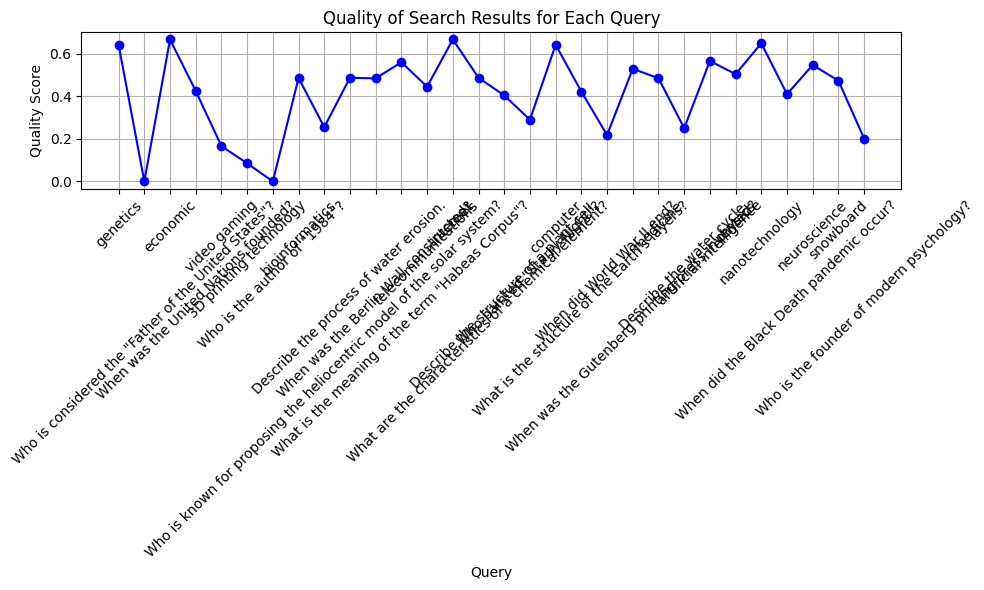

Average duration: 6.261380831400554 seconds
Maximum quality score: 0.667
Minimum quality score: 0.0
Average quality score: 0.41486666666666666


In [28]:
qs_res

import matplotlib.pyplot as plt
import numpy as np

# Extract durations and quality scores from qs_res
durations = [entry[1] for entry in qs_res]
quality_scores = [entry[2] for entry in qs_res]

# Plot quality scores
plt.figure(figsize=(10, 6))
plt.plot(quality_scores, marker='o', linestyle='-', color='b')
plt.title('Quality of Search Results for Each Query')
plt.xlabel('Query')
plt.ylabel('Quality Score')
plt.grid(True)
plt.xticks(np.arange(len(quality_scores)), [entry[0] for entry in qs_res], rotation=45)
plt.tight_layout()
plt.show()

# Calculate statistics
avg_duration = np.mean(durations)
max_quality = max(quality_scores)
min_quality = min(quality_scores)
avg_quality = np.mean(quality_scores)

print(f'Average duration: {avg_duration} seconds')
print(f'Maximum quality score: {max_quality}')
print(f'Minimum quality score: {min_quality}')
print(f'Average quality score: {avg_quality}')

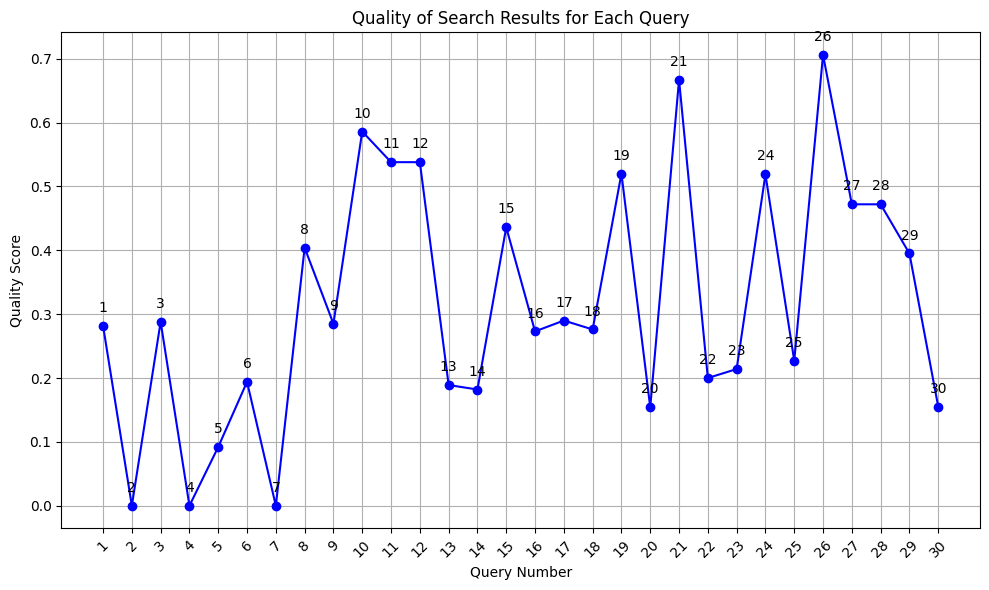

Average duration: 6.467651359240214 seconds
Maximum quality score: 0.706
Minimum quality score: 0.0
Average quality score: 0.3184666666666666


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assign query numbers
query_numbers = np.arange(len(quality_scores)) + 1

# Extract durations and quality scores from qs_res
durations = [entry[1] for entry in qs_res]
quality_scores = [entry[2] for entry in qs_res]

# Plot quality scores
plt.figure(figsize=(10, 6))
plt.plot(quality_scores, marker='o', linestyle='-', color='b')
plt.title('Quality of Search Results for Each Query')
plt.xlabel('Query Number')
plt.ylabel('Quality Score')
plt.grid(True)
plt.xticks(np.arange(len(quality_scores)), query_numbers, rotation=45)
plt.tight_layout()

# Annotate the plot with query numbers
for i, txt in enumerate(query_numbers):
    plt.annotate(txt, (i, quality_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Calculate statistics
avg_duration = np.mean(durations)
max_quality = max(quality_scores)
min_quality = min(quality_scores)
avg_quality = np.mean(quality_scores)

print(f'Average duration: {avg_duration} seconds')
print(f'Maximum quality score: {max_quality}')
print(f'Minimum quality score: {min_quality}')
print(f'Average quality score: {avg_quality}')
